<a href="https://colab.research.google.com/github/AdamPeetz/PlaneGAN/blob/main/MSDS696_GAN_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# example of a dcgan on cifar10
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
import tensorflow as tf
import cv2
import numpy as np
import pathlib

import os, shutil 
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 16x16
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 8x8
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 4x4
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model


In [3]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [5]:
# load and prepare cifar10 training images
def load_real_samples():
	# load cifar10 dataset
	(trainX, _), (_, _) = load_data()
	# convert from unsigned ints to floats
	X = trainX.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

#load and prepare custom image dataset
def create_real_img_dataset(image_path, resize_dim):
		dataset = []
		for file in tqdm(os.listdir(image_path)):
				image = cv2.imread(os.path.join(image_path,file))
				X = image.astype('float32')
				X = X[:, :, [2, 1, 0]]
				X = (X - 127.5) / 127.5
				X = tf.image.resize(X, [resize_dim, resize_dim])
				dataset.append(X)
		dataset = np.array(dataset)
		return dataset

#load a custom image dataset with 1 level of directory
# tensorflow documentation
def load_custom_image_set(dataroot,resizedim,directorylevels):
    #image parse function
    def parse_image(filename):
        parts = tf.strings.split(filename, os.sep)
        label = parts[-2]
        image = tf.io.read_file(filename)
        image = tf.io.decode_jpeg(image)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [resizedim,resizedim])
        image = (image * 2) -1
        return image, label
    
    data_root = pathlib.Path(dataroot)
    if directorylevels == 1:
      list_ds = tf.data.Dataset.list_files(str(data_root/'*/*'))
    if directorylevels == 2:
      list_ds = tf.data.Dataset.list_files(str(data_root/'*/*/*'))
    images_ds = list_ds.map(parse_image)
    #https://stackoverflow.com/questions/70535683/extract-data-from-tensorflow-dataset-e-g-to-numpy
    images = np.asarray(list(images_ds.map(lambda x, y: x)))
    return images

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# modified with suggestion from Das Shuvo (2020)
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	input_tensor = tf.convert_to_tensor(x_input)
	X = g_model(input_tensor)
	X = X.numpy()
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [6]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
#	example = (examples + 1) * 255
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = '/content/gdrive/My Drive/planegan/sample_output/generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
	# plot loss
	pyplot.subplot(2, 1, 1)
	pyplot.plot(d1_hist, label='d-real')
	pyplot.plot(d2_hist, label='d-fake')
	pyplot.plot(g_hist, label='gen')
	pyplot.legend()
	# plot discriminator accuracy
	pyplot.subplot(2, 1, 2)
	pyplot.plot(a1_hist, label='acc-real')
	pyplot.plot(a2_hist, label='acc-fake')
	pyplot.legend()
	# save plot to file
	pyplot.savefig('/content/gdrive/My Drive/planegan/saved_models/plot_line_plot_loss.png')
	pyplot.close()


In [8]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = '/content/gdrive/My Drive/planegan/saved_models/generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=300, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# define half batches for training
	half_batch = int(n_batch / 2)
  # prepare lists for storing stats each iteration
	d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
		# summarize loss
			if (j+1) % 5 == 0:
				print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
		# record training metrics
		if (i+1) % 2 == 0:
			d1_hist.append(d_loss1)
			d2_hist.append(d_loss2)
			g_hist.append(g_loss)
			a1_hist.append(d_acc1)
			a2_hist.append(d_acc2)
	# save plot to directory
	plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)


In [11]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
image_path = "/content/gdrive/My Drive/cars_tanks/"
resizedim = 32
directorylevels = 2
dataset = load_custom_image_set(image_path,resizedim,directorylevels)
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 5/11, d1=0.334, d2=0.773 g=0.632
>1, 10/11, d1=0.101, d2=0.701 g=0.827
>2, 5/11, d1=0.096, d2=0.760 g=0.793
>2, 10/11, d1=0.338, d2=0.548 g=1.052
>3, 5/11, d1=0.031, d2=0.639 g=0.764
>3, 10/11, d1=0.019, d2=0.736 g=0.830
>4, 5/11, d1=0.017, d2=0.408 g=1.201
>4, 10/11, d1=0.048, d2=0.184 g=2.250
>5, 5/11, d1=0.000, d2=0.851 g=2.525
>5, 10/11, d1=0.051, d2=0.183 g=5.092
>6, 5/11, d1=0.019, d2=0.583 g=4.829
>6, 10/11, d1=0.006, d2=0.021 g=5.800
>7, 5/11, d1=0.005, d2=0.091 g=3.835
>7, 10/11, d1=0.066, d2=0.258 g=5.474
>8, 5/11, d1=0.616, d2=0.294 g=2.965
>8, 10/11, d1=0.428, d2=0.136 g=3.234
>9, 5/11, d1=0.207, d2=0.348 g=6.147
>9, 10/11, d1=0.095, d2=0.254 g=3.737
>10, 5/11, d1=0.548, d2=0.429 g=3.271
>10, 10/11, d1=0.452, d2=0.240 g=2.872
>Accuracy real: 88%, fake: 91%


>11, 5/11, d1=0.353, d2=0.237 g=4.249
>11, 10/11, d1=0.332, d2=0.148 g=3.735
>12, 5/11, d1=0.147, d2=0.238 g=5.563
>12, 10/11, d1=0.636, d2=0.327 g=4.071
>13, 5/11, d1=0.511, d2=0.209 g=3.009
>13, 10/11, d1=0.483, d2=0.223 g=3.789
>14, 5/11, d1=0.214, d2=0.160 g=3.322
>14, 10/11, d1=0.157, d2=0.215 g=3.449
>15, 5/11, d1=0.361, d2=0.806 g=1.737
>15, 10/11, d1=0.273, d2=0.263 g=2.464
>16, 5/11, d1=0.287, d2=0.514 g=2.716
>16, 10/11, d1=0.450, d2=0.309 g=2.917
>17, 5/11, d1=0.723, d2=0.482 g=2.546
>17, 10/11, d1=0.502, d2=0.611 g=1.803
>18, 5/11, d1=0.412, d2=0.261 g=2.133
>18, 10/11, d1=0.181, d2=0.178 g=3.040
>19, 5/11, d1=0.296, d2=0.173 g=3.419
>19, 10/11, d1=0.602, d2=0.584 g=4.519
>20, 5/11, d1=0.669, d2=1.263 g=2.916
>20, 10/11, d1=0.537, d2=0.446 g=2.259
>Accuracy real: 77%, fake: 99%


>21, 5/11, d1=0.765, d2=0.251 g=2.801
>21, 10/11, d1=0.513, d2=0.433 g=3.015
>22, 5/11, d1=0.521, d2=0.355 g=2.538
>22, 10/11, d1=0.309, d2=0.343 g=3.232
>23, 5/11, d1=0.724, d2=0.453 g=2.421
>23, 10/11, d1=0.705, d2=0.348 g=2.591
>24, 5/11, d1=0.604, d2=0.423 g=1.804
>24, 10/11, d1=0.563, d2=0.302 g=2.057
>25, 5/11, d1=0.649, d2=0.577 g=1.767
>25, 10/11, d1=0.528, d2=0.447 g=1.935
>26, 5/11, d1=0.774, d2=0.502 g=1.742
>26, 10/11, d1=0.388, d2=0.289 g=2.219
>27, 5/11, d1=0.455, d2=0.423 g=2.396
>27, 10/11, d1=0.827, d2=0.821 g=1.626
>28, 5/11, d1=0.550, d2=0.511 g=1.718
>28, 10/11, d1=0.351, d2=0.313 g=2.037
>29, 5/11, d1=0.561, d2=0.500 g=2.015
>29, 10/11, d1=0.413, d2=0.433 g=1.769
>30, 5/11, d1=0.451, d2=0.627 g=1.408
>30, 10/11, d1=0.442, d2=0.580 g=1.408
>Accuracy real: 88%, fake: 100%


>31, 5/11, d1=0.295, d2=0.386 g=1.847
>31, 10/11, d1=0.306, d2=0.268 g=2.369
>32, 5/11, d1=0.524, d2=0.493 g=2.348
>32, 10/11, d1=0.436, d2=0.481 g=2.476
>33, 5/11, d1=0.554, d2=0.468 g=2.103
>33, 10/11, d1=0.521, d2=0.241 g=2.630
>34, 5/11, d1=0.338, d2=0.305 g=2.672
>34, 10/11, d1=0.355, d2=0.247 g=2.790
>35, 5/11, d1=0.723, d2=1.075 g=2.655
>35, 10/11, d1=0.660, d2=0.743 g=1.821
>36, 5/11, d1=0.441, d2=0.358 g=1.970
>36, 10/11, d1=0.640, d2=0.638 g=2.413
>37, 5/11, d1=0.882, d2=0.631 g=1.551
>37, 10/11, d1=0.716, d2=0.421 g=1.822
>38, 5/11, d1=0.707, d2=0.493 g=1.575
>38, 10/11, d1=0.741, d2=0.502 g=1.584
>39, 5/11, d1=0.613, d2=0.401 g=1.799
>39, 10/11, d1=0.431, d2=0.374 g=2.133
>40, 5/11, d1=0.623, d2=0.326 g=2.237
>40, 10/11, d1=0.546, d2=0.466 g=1.981
>Accuracy real: 63%, fake: 65%


>41, 5/11, d1=0.638, d2=0.660 g=1.512
>41, 10/11, d1=0.597, d2=0.554 g=1.414
>42, 5/11, d1=0.629, d2=0.496 g=1.349
>42, 10/11, d1=0.640, d2=0.329 g=1.590
>43, 5/11, d1=0.346, d2=0.408 g=1.995
>43, 10/11, d1=0.723, d2=0.615 g=1.501
>44, 5/11, d1=0.658, d2=0.431 g=1.494
>44, 10/11, d1=0.675, d2=0.729 g=1.136
>45, 5/11, d1=0.594, d2=0.640 g=1.205
>45, 10/11, d1=0.534, d2=0.583 g=1.218
>46, 5/11, d1=0.472, d2=0.506 g=1.375
>46, 10/11, d1=0.603, d2=0.510 g=1.409
>47, 5/11, d1=0.541, d2=0.453 g=1.575
>47, 10/11, d1=0.391, d2=0.435 g=1.791
>48, 5/11, d1=0.704, d2=0.724 g=1.647
>48, 10/11, d1=0.812, d2=0.598 g=1.548
>49, 5/11, d1=0.456, d2=0.319 g=1.852
>49, 10/11, d1=0.381, d2=0.276 g=1.979
>50, 5/11, d1=0.502, d2=0.491 g=1.834
>50, 10/11, d1=0.599, d2=0.662 g=1.694
>Accuracy real: 54%, fake: 75%


>51, 5/11, d1=0.603, d2=0.426 g=1.980
>51, 10/11, d1=0.615, d2=0.478 g=1.719
>52, 5/11, d1=0.695, d2=0.605 g=1.488
>52, 10/11, d1=0.551, d2=0.360 g=1.674
>53, 5/11, d1=0.435, d2=0.656 g=1.497
>53, 10/11, d1=0.735, d2=0.521 g=1.566
>54, 5/11, d1=0.472, d2=0.501 g=1.630
>54, 10/11, d1=0.512, d2=0.584 g=1.692
>55, 5/11, d1=0.768, d2=0.540 g=1.340
>55, 10/11, d1=0.381, d2=0.385 g=1.661
>56, 5/11, d1=0.496, d2=0.651 g=1.345
>56, 10/11, d1=0.622, d2=0.661 g=1.322
>57, 5/11, d1=0.596, d2=0.590 g=1.565
>57, 10/11, d1=0.563, d2=0.523 g=1.465
>58, 5/11, d1=0.541, d2=0.630 g=1.377
>58, 10/11, d1=0.530, d2=0.644 g=1.185
>59, 5/11, d1=0.517, d2=0.492 g=1.293
>59, 10/11, d1=0.469, d2=0.522 g=1.405
>60, 5/11, d1=0.650, d2=0.649 g=1.184
>60, 10/11, d1=0.675, d2=0.567 g=1.296
>Accuracy real: 60%, fake: 92%


>61, 5/11, d1=0.706, d2=0.625 g=1.263
>61, 10/11, d1=0.584, d2=0.528 g=1.366
>62, 5/11, d1=0.664, d2=0.465 g=1.337
>62, 10/11, d1=0.518, d2=0.443 g=1.414
>63, 5/11, d1=0.594, d2=0.521 g=1.428
>63, 10/11, d1=0.569, d2=0.713 g=1.312
>64, 5/11, d1=0.576, d2=0.601 g=1.212
>64, 10/11, d1=0.631, d2=0.602 g=1.310
>65, 5/11, d1=0.645, d2=0.426 g=1.384
>65, 10/11, d1=0.572, d2=0.440 g=1.695
>66, 5/11, d1=0.744, d2=0.671 g=1.251
>66, 10/11, d1=0.526, d2=0.585 g=1.261
>67, 5/11, d1=0.549, d2=0.598 g=1.109
>67, 10/11, d1=0.592, d2=0.738 g=0.988
>68, 5/11, d1=0.613, d2=0.807 g=0.914
>68, 10/11, d1=0.648, d2=0.565 g=1.117
>69, 5/11, d1=0.478, d2=0.508 g=1.335
>69, 10/11, d1=0.519, d2=0.538 g=1.441
>70, 5/11, d1=0.527, d2=0.472 g=1.758
>70, 10/11, d1=0.496, d2=0.577 g=1.622
>Accuracy real: 59%, fake: 69%


>71, 5/11, d1=0.740, d2=0.557 g=1.372
>71, 10/11, d1=0.578, d2=0.367 g=1.787
>72, 5/11, d1=0.481, d2=0.452 g=1.475
>72, 10/11, d1=0.588, d2=0.622 g=1.322
>73, 5/11, d1=0.730, d2=0.660 g=1.089
>73, 10/11, d1=0.614, d2=0.601 g=1.204
>74, 5/11, d1=0.480, d2=0.471 g=1.352
>74, 10/11, d1=0.416, d2=0.442 g=1.480
>75, 5/11, d1=0.548, d2=0.528 g=1.367
>75, 10/11, d1=0.589, d2=0.469 g=1.589
>76, 5/11, d1=0.501, d2=0.572 g=1.601
>76, 10/11, d1=0.521, d2=0.682 g=1.358
>77, 5/11, d1=0.600, d2=0.557 g=1.412
>77, 10/11, d1=0.489, d2=0.409 g=1.652
>78, 5/11, d1=0.592, d2=0.534 g=1.697
>78, 10/11, d1=0.666, d2=0.527 g=1.662
>79, 5/11, d1=0.640, d2=0.568 g=1.521
>79, 10/11, d1=0.802, d2=0.539 g=1.539
>80, 5/11, d1=0.579, d2=0.450 g=1.709
>80, 10/11, d1=0.606, d2=0.500 g=1.619
>Accuracy real: 64%, fake: 61%


>81, 5/11, d1=0.577, d2=0.357 g=1.708
>81, 10/11, d1=0.447, d2=0.459 g=1.867
>82, 5/11, d1=0.812, d2=0.682 g=1.681
>82, 10/11, d1=0.676, d2=0.594 g=1.366
>83, 5/11, d1=0.531, d2=0.494 g=1.349
>83, 10/11, d1=0.538, d2=0.575 g=1.350
>84, 5/11, d1=0.530, d2=0.455 g=1.505
>84, 10/11, d1=0.605, d2=0.607 g=1.432
>85, 5/11, d1=0.501, d2=0.448 g=1.477
>85, 10/11, d1=0.391, d2=0.443 g=1.714
>86, 5/11, d1=0.475, d2=0.495 g=1.598
>86, 10/11, d1=0.861, d2=0.735 g=1.533
>87, 5/11, d1=0.589, d2=0.503 g=1.480
>87, 10/11, d1=0.545, d2=0.473 g=1.506
>88, 5/11, d1=0.535, d2=0.575 g=1.290
>88, 10/11, d1=0.639, d2=0.492 g=1.343
>89, 5/11, d1=0.478, d2=0.456 g=1.455
>89, 10/11, d1=0.525, d2=0.705 g=1.267
>90, 5/11, d1=0.497, d2=0.437 g=1.490
>90, 10/11, d1=0.613, d2=0.553 g=1.720
>Accuracy real: 64%, fake: 97%


>91, 5/11, d1=0.494, d2=0.428 g=2.034
>91, 10/11, d1=0.495, d2=0.554 g=1.754
>92, 5/11, d1=0.770, d2=0.504 g=1.553
>92, 10/11, d1=0.582, d2=0.385 g=1.925
>93, 5/11, d1=0.717, d2=0.502 g=2.245
>93, 10/11, d1=0.834, d2=0.498 g=1.899
>94, 5/11, d1=0.560, d2=0.481 g=1.867
>94, 10/11, d1=0.564, d2=0.613 g=1.392
>95, 5/11, d1=0.676, d2=0.701 g=1.295
>95, 10/11, d1=0.603, d2=0.461 g=1.461
>96, 5/11, d1=0.485, d2=0.439 g=1.720
>96, 10/11, d1=0.422, d2=0.494 g=1.692
>97, 5/11, d1=0.495, d2=0.478 g=1.643
>97, 10/11, d1=0.546, d2=0.472 g=1.734
>98, 5/11, d1=0.692, d2=0.569 g=1.983
>98, 10/11, d1=0.839, d2=0.669 g=2.180
>99, 5/11, d1=0.844, d2=0.625 g=1.481
>99, 10/11, d1=0.636, d2=0.599 g=1.308
>100, 5/11, d1=0.606, d2=0.446 g=1.509
>100, 10/11, d1=0.562, d2=0.444 g=1.688
>Accuracy real: 87%, fake: 97%


>101, 5/11, d1=0.466, d2=0.460 g=1.598
>101, 10/11, d1=0.504, d2=0.548 g=1.437
>102, 5/11, d1=0.538, d2=0.523 g=1.280
>102, 10/11, d1=0.523, d2=0.626 g=1.441
>103, 5/11, d1=0.439, d2=0.544 g=1.442
>103, 10/11, d1=0.571, d2=0.478 g=1.635
>104, 5/11, d1=0.679, d2=0.496 g=1.414
>104, 10/11, d1=0.564, d2=0.607 g=1.407
>105, 5/11, d1=0.521, d2=0.565 g=1.562
>105, 10/11, d1=0.708, d2=0.689 g=1.367
>106, 5/11, d1=0.615, d2=0.474 g=1.484
>106, 10/11, d1=0.576, d2=0.593 g=1.204
>107, 5/11, d1=0.657, d2=0.744 g=1.150
>107, 10/11, d1=0.678, d2=0.837 g=1.156
>108, 5/11, d1=0.559, d2=0.546 g=1.229
>108, 10/11, d1=0.586, d2=0.557 g=1.256
>109, 5/11, d1=0.526, d2=0.489 g=1.222
>109, 10/11, d1=0.589, d2=0.562 g=1.261
>110, 5/11, d1=0.470, d2=0.553 g=1.234
>110, 10/11, d1=0.585, d2=0.586 g=1.478
>Accuracy real: 73%, fake: 83%


>111, 5/11, d1=0.485, d2=0.420 g=1.587
>111, 10/11, d1=0.528, d2=0.529 g=1.529
>112, 5/11, d1=0.626, d2=0.571 g=1.481
>112, 10/11, d1=0.590, d2=0.498 g=1.547
>113, 5/11, d1=0.551, d2=0.587 g=1.653
>113, 10/11, d1=0.484, d2=0.617 g=1.771
>114, 5/11, d1=0.488, d2=0.447 g=2.266
>114, 10/11, d1=0.761, d2=0.512 g=1.830
>115, 5/11, d1=0.527, d2=0.597 g=1.449
>115, 10/11, d1=0.577, d2=0.707 g=1.512
>116, 5/11, d1=0.587, d2=0.566 g=1.650
>116, 10/11, d1=0.496, d2=0.368 g=1.897
>117, 5/11, d1=0.529, d2=0.449 g=1.949
>117, 10/11, d1=0.761, d2=0.506 g=1.820
>118, 5/11, d1=0.542, d2=0.475 g=1.850
>118, 10/11, d1=0.525, d2=0.497 g=1.569
>119, 5/11, d1=0.471, d2=0.490 g=1.494
>119, 10/11, d1=0.558, d2=0.449 g=1.618
>120, 5/11, d1=0.594, d2=0.403 g=1.746
>120, 10/11, d1=0.522, d2=0.554 g=1.630
>Accuracy real: 77%, fake: 82%


>121, 5/11, d1=0.513, d2=0.485 g=1.560
>121, 10/11, d1=0.488, d2=0.573 g=1.456
>122, 5/11, d1=0.631, d2=0.499 g=1.565
>122, 10/11, d1=0.799, d2=0.574 g=1.177
>123, 5/11, d1=0.588, d2=0.600 g=1.369
>123, 10/11, d1=0.567, d2=0.520 g=1.377
>124, 5/11, d1=0.687, d2=0.575 g=1.413
>124, 10/11, d1=0.515, d2=0.573 g=1.744
>125, 5/11, d1=0.640, d2=0.489 g=1.499
>125, 10/11, d1=0.500, d2=0.470 g=1.433
>126, 5/11, d1=0.623, d2=0.455 g=1.524
>126, 10/11, d1=0.605, d2=0.458 g=1.606
>127, 5/11, d1=0.511, d2=0.558 g=1.462
>127, 10/11, d1=0.619, d2=0.440 g=1.645
>128, 5/11, d1=0.552, d2=0.699 g=1.179
>128, 10/11, d1=0.677, d2=0.727 g=1.219
>129, 5/11, d1=0.523, d2=0.526 g=1.445
>129, 10/11, d1=0.446, d2=0.575 g=1.346
>130, 5/11, d1=0.553, d2=0.473 g=1.554
>130, 10/11, d1=0.625, d2=0.576 g=1.163
>Accuracy real: 63%, fake: 65%


>131, 5/11, d1=0.672, d2=0.717 g=0.930
>131, 10/11, d1=0.532, d2=0.593 g=1.133
>132, 5/11, d1=0.468, d2=0.571 g=1.179
>132, 10/11, d1=0.703, d2=0.592 g=1.265
>133, 5/11, d1=0.489, d2=0.376 g=1.507
>133, 10/11, d1=0.515, d2=0.521 g=1.529
>134, 5/11, d1=0.624, d2=0.449 g=1.429
>134, 10/11, d1=0.559, d2=0.450 g=1.556
>135, 5/11, d1=0.617, d2=0.481 g=1.626
>135, 10/11, d1=0.545, d2=0.399 g=1.836
>136, 5/11, d1=0.566, d2=0.480 g=2.156
>136, 10/11, d1=0.746, d2=0.652 g=2.037
>137, 5/11, d1=0.598, d2=0.528 g=1.786
>137, 10/11, d1=0.536, d2=0.561 g=1.427
>138, 5/11, d1=0.481, d2=0.561 g=1.427
>138, 10/11, d1=0.550, d2=0.638 g=1.436
>139, 5/11, d1=0.833, d2=0.581 g=1.182
>139, 10/11, d1=0.607, d2=0.504 g=1.449
>140, 5/11, d1=0.564, d2=0.487 g=1.484
>140, 10/11, d1=0.443, d2=0.477 g=1.715
>Accuracy real: 79%, fake: 80%


>141, 5/11, d1=0.550, d2=0.742 g=1.456
>141, 10/11, d1=0.690, d2=0.673 g=1.284
>142, 5/11, d1=0.478, d2=0.488 g=1.355
>142, 10/11, d1=0.621, d2=0.527 g=1.291
>143, 5/11, d1=0.534, d2=0.486 g=1.583
>143, 10/11, d1=0.617, d2=0.531 g=1.522
>144, 5/11, d1=0.507, d2=0.470 g=1.556
>144, 10/11, d1=0.811, d2=0.555 g=1.355
>145, 5/11, d1=0.639, d2=0.429 g=1.519
>145, 10/11, d1=0.473, d2=0.423 g=1.652
>146, 5/11, d1=0.476, d2=0.479 g=1.592
>146, 10/11, d1=0.638, d2=0.653 g=1.183
>147, 5/11, d1=0.818, d2=0.717 g=1.211
>147, 10/11, d1=0.501, d2=0.574 g=1.561
>148, 5/11, d1=0.549, d2=0.539 g=1.557
>148, 10/11, d1=0.524, d2=0.467 g=1.356
>149, 5/11, d1=0.490, d2=0.480 g=1.355
>149, 10/11, d1=0.575, d2=0.639 g=1.094
>150, 5/11, d1=0.433, d2=0.479 g=1.539
>150, 10/11, d1=0.441, d2=0.509 g=1.473
>Accuracy real: 79%, fake: 83%


>151, 5/11, d1=0.468, d2=0.518 g=1.338
>151, 10/11, d1=0.432, d2=0.508 g=1.400
>152, 5/11, d1=0.587, d2=0.640 g=1.572
>152, 10/11, d1=0.660, d2=0.468 g=1.639
>153, 5/11, d1=0.646, d2=0.570 g=1.336
>153, 10/11, d1=0.599, d2=0.573 g=1.530
>154, 5/11, d1=0.525, d2=0.547 g=1.611
>154, 10/11, d1=1.056, d2=0.577 g=1.618
>155, 5/11, d1=0.625, d2=0.399 g=1.811
>155, 10/11, d1=0.565, d2=0.554 g=1.276
>156, 5/11, d1=0.583, d2=0.569 g=1.235
>156, 10/11, d1=0.460, d2=0.465 g=1.573
>157, 5/11, d1=0.597, d2=0.621 g=1.343
>157, 10/11, d1=0.660, d2=0.547 g=1.431
>158, 5/11, d1=0.494, d2=0.512 g=1.425
>158, 10/11, d1=0.509, d2=0.593 g=1.368
>159, 5/11, d1=0.703, d2=0.613 g=1.388
>159, 10/11, d1=0.539, d2=0.506 g=1.468
>160, 5/11, d1=0.521, d2=0.510 g=1.464
>160, 10/11, d1=0.428, d2=0.417 g=1.624
>Accuracy real: 80%, fake: 94%


>161, 5/11, d1=0.523, d2=0.625 g=1.415
>161, 10/11, d1=0.495, d2=0.508 g=1.772
>162, 5/11, d1=0.756, d2=0.637 g=1.861
>162, 10/11, d1=0.558, d2=0.663 g=1.932
>163, 5/11, d1=0.726, d2=0.698 g=1.379
>163, 10/11, d1=0.702, d2=0.450 g=1.705
>164, 5/11, d1=0.439, d2=0.861 g=1.687
>164, 10/11, d1=0.800, d2=0.423 g=1.989
>165, 5/11, d1=0.476, d2=0.516 g=1.577
>165, 10/11, d1=0.761, d2=0.610 g=1.200
>166, 5/11, d1=0.477, d2=0.451 g=1.500
>166, 10/11, d1=0.517, d2=0.522 g=1.483
>167, 5/11, d1=0.645, d2=0.442 g=1.643
>167, 10/11, d1=0.556, d2=0.599 g=1.362
>168, 5/11, d1=0.763, d2=0.556 g=1.394
>168, 10/11, d1=0.441, d2=0.455 g=1.614
>169, 5/11, d1=0.590, d2=0.658 g=1.699
>169, 10/11, d1=0.676, d2=0.475 g=1.531
>170, 5/11, d1=0.623, d2=0.522 g=1.457
>170, 10/11, d1=0.524, d2=0.486 g=1.366
>Accuracy real: 84%, fake: 80%


>171, 5/11, d1=0.388, d2=0.586 g=1.577
>171, 10/11, d1=0.546, d2=0.588 g=1.524
>172, 5/11, d1=0.502, d2=0.508 g=1.720
>172, 10/11, d1=0.588, d2=0.414 g=1.811
>173, 5/11, d1=0.414, d2=0.459 g=1.571
>173, 10/11, d1=0.421, d2=0.446 g=1.587
>174, 5/11, d1=0.619, d2=0.461 g=1.833
>174, 10/11, d1=0.536, d2=0.659 g=1.591
>175, 5/11, d1=0.467, d2=0.374 g=1.740
>175, 10/11, d1=0.510, d2=0.504 g=1.497
>176, 5/11, d1=0.508, d2=0.526 g=1.683
>176, 10/11, d1=0.675, d2=0.496 g=1.745
>177, 5/11, d1=0.390, d2=0.436 g=1.728
>177, 10/11, d1=0.421, d2=0.569 g=1.470
>178, 5/11, d1=0.476, d2=0.376 g=1.980
>178, 10/11, d1=0.493, d2=0.939 g=1.832
>179, 5/11, d1=0.790, d2=0.519 g=1.495
>179, 10/11, d1=0.547, d2=0.454 g=1.441
>180, 5/11, d1=0.610, d2=0.654 g=1.489
>180, 10/11, d1=0.493, d2=0.438 g=1.508
>Accuracy real: 73%, fake: 91%


>181, 5/11, d1=0.637, d2=0.541 g=1.576
>181, 10/11, d1=0.676, d2=0.408 g=1.601
>182, 5/11, d1=0.474, d2=0.543 g=1.453
>182, 10/11, d1=0.485, d2=0.455 g=1.496
>183, 5/11, d1=0.436, d2=0.386 g=1.690
>183, 10/11, d1=0.754, d2=0.587 g=1.708
>184, 5/11, d1=0.439, d2=0.560 g=1.476
>184, 10/11, d1=0.635, d2=0.666 g=1.370
>185, 5/11, d1=0.638, d2=0.601 g=1.597
>185, 10/11, d1=0.552, d2=0.488 g=1.542
>186, 5/11, d1=0.469, d2=0.467 g=1.576
>186, 10/11, d1=0.523, d2=0.606 g=1.535
>187, 5/11, d1=0.584, d2=0.658 g=1.692
>187, 10/11, d1=0.702, d2=0.466 g=1.749
>188, 5/11, d1=0.675, d2=0.454 g=1.490
>188, 10/11, d1=0.515, d2=0.406 g=1.708
>189, 5/11, d1=0.543, d2=0.452 g=1.790
>189, 10/11, d1=0.510, d2=0.529 g=1.762
>190, 5/11, d1=0.609, d2=0.640 g=1.579
>190, 10/11, d1=0.590, d2=0.623 g=1.398
>Accuracy real: 64%, fake: 71%


>191, 5/11, d1=0.489, d2=0.730 g=1.417
>191, 10/11, d1=0.523, d2=0.487 g=1.631
>192, 5/11, d1=0.425, d2=0.416 g=1.744
>192, 10/11, d1=0.744, d2=0.620 g=1.738
>193, 5/11, d1=0.539, d2=0.462 g=2.044
>193, 10/11, d1=0.783, d2=0.670 g=1.743
>194, 5/11, d1=0.661, d2=0.437 g=1.839
>194, 10/11, d1=0.485, d2=0.404 g=1.673
>195, 5/11, d1=0.592, d2=0.493 g=1.483
>195, 10/11, d1=0.580, d2=0.549 g=1.426
>196, 5/11, d1=0.509, d2=0.517 g=1.349
>196, 10/11, d1=0.523, d2=0.457 g=1.556
>197, 5/11, d1=0.468, d2=0.501 g=1.651
>197, 10/11, d1=0.403, d2=0.497 g=1.506
>198, 5/11, d1=0.549, d2=0.641 g=1.326
>198, 10/11, d1=0.485, d2=0.541 g=1.574
>199, 5/11, d1=0.589, d2=0.505 g=1.722
>199, 10/11, d1=0.609, d2=0.483 g=1.697
>200, 5/11, d1=0.648, d2=0.490 g=1.519
>200, 10/11, d1=0.576, d2=0.446 g=1.591
>Accuracy real: 69%, fake: 87%


>201, 5/11, d1=0.533, d2=0.361 g=1.758
>201, 10/11, d1=0.471, d2=0.485 g=1.867
>202, 5/11, d1=0.531, d2=0.426 g=1.719
>202, 10/11, d1=0.495, d2=0.622 g=1.572
>203, 5/11, d1=0.738, d2=0.572 g=1.362
>203, 10/11, d1=0.597, d2=0.475 g=1.723
>204, 5/11, d1=0.403, d2=0.348 g=1.920
>204, 10/11, d1=0.613, d2=0.562 g=1.874
>205, 5/11, d1=0.607, d2=0.400 g=1.813
>205, 10/11, d1=0.310, d2=0.534 g=1.783
>206, 5/11, d1=0.622, d2=0.531 g=1.704
>206, 10/11, d1=0.404, d2=0.568 g=1.766
>207, 5/11, d1=0.765, d2=0.634 g=1.690
>207, 10/11, d1=0.629, d2=0.536 g=1.626
>208, 5/11, d1=0.530, d2=0.500 g=1.508
>208, 10/11, d1=0.587, d2=0.463 g=1.500
>209, 5/11, d1=0.393, d2=0.278 g=1.917
>209, 10/11, d1=0.386, d2=0.409 g=1.758
>210, 5/11, d1=0.570, d2=0.541 g=1.457
>210, 10/11, d1=0.572, d2=0.431 g=1.508
>Accuracy real: 75%, fake: 85%


>211, 5/11, d1=0.405, d2=0.452 g=1.538
>211, 10/11, d1=0.518, d2=0.507 g=1.528
>212, 5/11, d1=0.594, d2=0.514 g=1.457
>212, 10/11, d1=0.805, d2=0.623 g=1.417
>213, 5/11, d1=0.598, d2=0.600 g=1.402
>213, 10/11, d1=0.741, d2=0.599 g=1.421
>214, 5/11, d1=0.523, d2=0.635 g=1.473
>214, 10/11, d1=0.608, d2=0.636 g=1.410
>215, 5/11, d1=0.492, d2=0.401 g=1.518
>215, 10/11, d1=0.484, d2=0.459 g=1.506
>216, 5/11, d1=0.537, d2=0.440 g=1.502
>216, 10/11, d1=0.571, d2=0.553 g=1.599
>217, 5/11, d1=0.608, d2=0.506 g=1.603
>217, 10/11, d1=0.666, d2=0.466 g=1.560
>218, 5/11, d1=0.686, d2=0.557 g=1.537
>218, 10/11, d1=0.521, d2=0.451 g=1.394
>219, 5/11, d1=0.661, d2=0.500 g=1.280
>219, 10/11, d1=0.530, d2=0.507 g=1.235
>220, 5/11, d1=0.593, d2=0.564 g=1.495
>220, 10/11, d1=0.480, d2=0.440 g=1.624
>Accuracy real: 69%, fake: 93%


>221, 5/11, d1=0.426, d2=0.368 g=1.616
>221, 10/11, d1=0.374, d2=0.469 g=1.666
>222, 5/11, d1=0.507, d2=0.605 g=1.613
>222, 10/11, d1=0.513, d2=0.466 g=1.655
>223, 5/11, d1=0.482, d2=0.575 g=1.508
>223, 10/11, d1=0.796, d2=0.632 g=1.570
>224, 5/11, d1=0.541, d2=0.472 g=1.444
>224, 10/11, d1=0.661, d2=0.447 g=1.575
>225, 5/11, d1=0.524, d2=0.382 g=1.649
>225, 10/11, d1=0.483, d2=0.393 g=1.464
>226, 5/11, d1=0.552, d2=0.566 g=1.485
>226, 10/11, d1=0.405, d2=0.418 g=1.595
>227, 5/11, d1=0.470, d2=0.538 g=1.614
>227, 10/11, d1=0.576, d2=0.400 g=1.805
>228, 5/11, d1=0.549, d2=0.557 g=1.862
>228, 10/11, d1=0.670, d2=0.561 g=1.688
>229, 5/11, d1=0.530, d2=0.688 g=1.660
>229, 10/11, d1=0.476, d2=0.381 g=1.772
>230, 5/11, d1=0.391, d2=0.564 g=1.813
>230, 10/11, d1=0.748, d2=0.363 g=1.995
>Accuracy real: 58%, fake: 97%


>231, 5/11, d1=0.365, d2=0.372 g=1.764
>231, 10/11, d1=0.586, d2=0.523 g=1.345
>232, 5/11, d1=0.545, d2=0.562 g=1.516
>232, 10/11, d1=0.331, d2=0.344 g=1.859
>233, 5/11, d1=0.493, d2=0.455 g=1.499
>233, 10/11, d1=0.406, d2=0.470 g=1.684
>234, 5/11, d1=0.722, d2=0.438 g=1.566
>234, 10/11, d1=0.715, d2=0.632 g=2.054
>235, 5/11, d1=0.621, d2=0.816 g=2.072
>235, 10/11, d1=0.396, d2=0.446 g=2.088
>236, 5/11, d1=0.530, d2=0.494 g=1.712
>236, 10/11, d1=0.536, d2=0.535 g=1.736
>237, 5/11, d1=0.487, d2=0.487 g=1.736
>237, 10/11, d1=0.493, d2=0.380 g=1.792
>238, 5/11, d1=0.656, d2=0.714 g=1.584
>238, 10/11, d1=0.531, d2=0.409 g=1.839
>239, 5/11, d1=0.392, d2=0.429 g=1.712
>239, 10/11, d1=0.565, d2=0.575 g=1.653
>240, 5/11, d1=0.464, d2=0.545 g=1.712
>240, 10/11, d1=0.566, d2=0.666 g=1.742
>Accuracy real: 71%, fake: 83%


>241, 5/11, d1=0.389, d2=0.284 g=2.008
>241, 10/11, d1=0.482, d2=0.371 g=2.064
>242, 5/11, d1=0.400, d2=0.497 g=1.993
>242, 10/11, d1=0.799, d2=1.026 g=2.727
>243, 5/11, d1=0.438, d2=0.515 g=1.667
>243, 10/11, d1=0.683, d2=0.453 g=1.853
>244, 5/11, d1=0.465, d2=0.474 g=1.757
>244, 10/11, d1=0.448, d2=0.461 g=1.531
>245, 5/11, d1=0.646, d2=0.682 g=1.514
>245, 10/11, d1=0.671, d2=0.517 g=1.588
>246, 5/11, d1=0.524, d2=0.440 g=1.667
>246, 10/11, d1=0.409, d2=0.393 g=1.859
>247, 5/11, d1=0.282, d2=0.398 g=1.902
>247, 10/11, d1=0.436, d2=0.460 g=1.645
>248, 5/11, d1=0.263, d2=0.417 g=1.885
>248, 10/11, d1=0.421, d2=0.661 g=2.122
>249, 5/11, d1=0.441, d2=0.507 g=2.014
>249, 10/11, d1=0.958, d2=0.748 g=2.174
>250, 5/11, d1=0.477, d2=0.600 g=1.472
>250, 10/11, d1=0.677, d2=0.591 g=1.339
>Accuracy real: 60%, fake: 81%


>251, 5/11, d1=0.634, d2=0.441 g=1.719
>251, 10/11, d1=0.528, d2=0.307 g=1.824
>252, 5/11, d1=0.500, d2=0.570 g=1.587
>252, 10/11, d1=0.387, d2=0.372 g=1.516
>253, 5/11, d1=0.310, d2=0.476 g=1.551
>253, 10/11, d1=0.467, d2=0.381 g=1.674
>254, 5/11, d1=0.578, d2=0.499 g=1.353
>254, 10/11, d1=0.392, d2=0.505 g=1.499
>255, 5/11, d1=0.568, d2=0.467 g=1.727
>255, 10/11, d1=0.581, d2=0.470 g=1.737
>256, 5/11, d1=0.664, d2=0.453 g=1.551
>256, 10/11, d1=0.420, d2=0.447 g=1.842
>257, 5/11, d1=0.453, d2=0.521 g=1.833
>257, 10/11, d1=0.486, d2=0.429 g=2.180
>258, 5/11, d1=0.436, d2=0.507 g=1.749
>258, 10/11, d1=0.600, d2=0.517 g=1.779
>259, 5/11, d1=0.553, d2=0.673 g=1.980
>259, 10/11, d1=0.520, d2=0.385 g=1.895
>260, 5/11, d1=0.489, d2=0.597 g=1.709
>260, 10/11, d1=0.946, d2=0.562 g=2.103
>Accuracy real: 54%, fake: 81%


>261, 5/11, d1=0.507, d2=0.387 g=1.717
>261, 10/11, d1=0.508, d2=0.508 g=1.685
>262, 5/11, d1=0.554, d2=0.352 g=1.712
>262, 10/11, d1=0.520, d2=0.501 g=1.474
>263, 5/11, d1=0.587, d2=0.533 g=1.701
>263, 10/11, d1=0.295, d2=0.357 g=1.674
>264, 5/11, d1=0.395, d2=0.394 g=1.573
>264, 10/11, d1=0.382, d2=0.358 g=1.939
>265, 5/11, d1=0.560, d2=0.196 g=2.198
>265, 10/11, d1=0.559, d2=0.569 g=1.876
>266, 5/11, d1=0.683, d2=0.520 g=2.201
>266, 10/11, d1=0.461, d2=0.355 g=1.913
>267, 5/11, d1=0.278, d2=0.575 g=2.065
>267, 10/11, d1=0.576, d2=0.655 g=2.111
>268, 5/11, d1=0.563, d2=0.711 g=2.177
>268, 10/11, d1=0.616, d2=0.454 g=1.658
>269, 5/11, d1=0.519, d2=0.422 g=1.491
>269, 10/11, d1=0.431, d2=0.476 g=1.513
>270, 5/11, d1=0.335, d2=0.356 g=1.797
>270, 10/11, d1=0.498, d2=0.390 g=1.820
>Accuracy real: 63%, fake: 91%


>271, 5/11, d1=0.575, d2=0.518 g=1.900
>271, 10/11, d1=0.707, d2=0.373 g=1.858
>272, 5/11, d1=0.581, d2=0.427 g=1.901
>272, 10/11, d1=0.890, d2=0.366 g=1.644
>273, 5/11, d1=0.480, d2=0.461 g=1.775
>273, 10/11, d1=0.645, d2=0.432 g=1.584
>274, 5/11, d1=0.602, d2=0.455 g=1.452
>274, 10/11, d1=0.489, d2=0.379 g=1.735
>275, 5/11, d1=0.321, d2=0.432 g=1.639
>275, 10/11, d1=0.363, d2=0.325 g=1.728
>276, 5/11, d1=0.431, d2=0.462 g=1.824
>276, 10/11, d1=0.454, d2=0.316 g=1.887
>277, 5/11, d1=0.487, d2=0.469 g=1.715
>277, 10/11, d1=0.623, d2=0.478 g=1.652
>278, 5/11, d1=0.516, d2=0.450 g=1.976
>278, 10/11, d1=0.332, d2=0.438 g=1.724
>279, 5/11, d1=0.404, d2=0.452 g=1.845
>279, 10/11, d1=0.515, d2=0.320 g=1.735
>280, 5/11, d1=0.283, d2=0.395 g=1.858
>280, 10/11, d1=0.521, d2=0.624 g=2.096
>Accuracy real: 56%, fake: 90%


>281, 5/11, d1=0.784, d2=0.534 g=2.200
>281, 10/11, d1=0.546, d2=0.398 g=1.687
>282, 5/11, d1=0.628, d2=0.418 g=1.765
>282, 10/11, d1=0.555, d2=0.594 g=1.741
>283, 5/11, d1=0.438, d2=0.467 g=1.742
>283, 10/11, d1=0.318, d2=0.377 g=1.902
>284, 5/11, d1=0.435, d2=0.741 g=2.042
>284, 10/11, d1=0.767, d2=0.680 g=1.676
>285, 5/11, d1=0.602, d2=0.368 g=1.876
>285, 10/11, d1=0.616, d2=0.488 g=1.704
>286, 5/11, d1=0.463, d2=0.487 g=1.774
>286, 10/11, d1=0.438, d2=0.416 g=1.853
>287, 5/11, d1=0.512, d2=0.555 g=1.970
>287, 10/11, d1=0.604, d2=0.369 g=1.713
>288, 5/11, d1=0.465, d2=0.468 g=1.784
>288, 10/11, d1=0.369, d2=0.406 g=1.752
>289, 5/11, d1=0.496, d2=0.381 g=1.598
>289, 10/11, d1=0.515, d2=0.553 g=1.863
>290, 5/11, d1=0.706, d2=0.458 g=1.816
>290, 10/11, d1=0.656, d2=0.676 g=2.298
>Accuracy real: 66%, fake: 93%


>291, 5/11, d1=0.579, d2=0.519 g=1.581
>291, 10/11, d1=0.508, d2=0.330 g=1.680
>292, 5/11, d1=0.369, d2=0.380 g=1.726
>292, 10/11, d1=0.398, d2=0.363 g=1.820
>293, 5/11, d1=0.543, d2=0.362 g=1.662
>293, 10/11, d1=0.706, d2=0.528 g=1.822
>294, 5/11, d1=0.444, d2=0.524 g=1.602
>294, 10/11, d1=0.446, d2=0.362 g=1.668
>295, 5/11, d1=0.277, d2=0.315 g=1.991
>295, 10/11, d1=0.430, d2=0.494 g=1.966
>296, 5/11, d1=0.596, d2=0.553 g=2.274
>296, 10/11, d1=0.710, d2=0.523 g=1.946
>297, 5/11, d1=0.625, d2=0.452 g=1.981
>297, 10/11, d1=0.648, d2=0.337 g=1.950
>298, 5/11, d1=0.372, d2=0.528 g=1.712
>298, 10/11, d1=0.469, d2=0.467 g=1.724
>299, 5/11, d1=0.577, d2=0.400 g=1.835
>299, 10/11, d1=0.423, d2=0.361 g=1.817
>300, 5/11, d1=0.564, d2=0.494 g=1.729
>300, 10/11, d1=0.456, d2=0.415 g=1.856
>Accuracy real: 74%, fake: 93%


4/4 [==============================] - 1s 55ms/step


IndexError: ignored

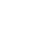

In [13]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

# load model
model = gan_model
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

# References

Brownlee, Jason. (2019). Generative Adversarial Networks with Python. Ebook. Machine Learning Mastery. 

Das Shuvo, Falguni. (2020). Repeatedly calling model.predict(...) results in memory leak. GitHub. Retrieved 3/15/2023 from https://github.com/keras-team/keras/issues/13118